In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np

In [2]:
quote_text = pd.read_csv('GNI88.csv')

In [3]:
article_data = pd.read_json("gni88.json", lines=True)
article_data.head()

,Article ID,Headline,Content,Media Name,Author,Published Date
0,3777409,Modernized Tu-160 to boost Russia's long-range...,Modernized Tu-160 to boost Russia's long-range...,Defense News,"Bodner, Matthew",2018-02-15 00:00:00+00
1,3764250,Give Trump more nuclear weapons and more ways ...,Give Trump more nuclear weapons and more ways ...,CNN,"Collina, Tom Z.",2018-02-02 00:00:00+00
2,3764251,Trump wants to build smaller atomic weapons; R...,Trump wants to build smaller atomic weapons; R...,Los Angeles Times,"Cloud, David",2018-02-03 00:00:00+00
3,3764252,Egypt and Israel Secretly Allied In Sinai Battle,Egypt and Israel Secretly Allied In Sinai Batt...,The New York Times,"Kirkpatrick, David D.",2018-02-04 00:00:00+00
4,3764253,Listen: Top Armed Services Dem worried about r...,Listen: Top Armed Services Dem worried about r...,The Hill,"Simendinger, Alexis",2018-02-03 00:00:00+00


In [4]:
len(article_data)

69995

# Extract first 10% of article content

make new content column -- does not include title, author, date

In [5]:
# only take everything after date in content
def justContent(content):
    content = ''.join(content.split('\r\n\r\n')[2:])
    return content

In [6]:
article_data['Content2'] = article_data['Content'].apply(lambda x: justContent(x))

In [7]:
article_data['First_10%_Content_Split'] = article_data['Content2'].apply(lambda x: x.split()[:int(0.1*len(x))])

In [8]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
article_data['First_10%_Content'] = article_data['First_10%_Content_Split'].apply(lambda x: TreebankWordDetokenizer().detokenize(x))

In [9]:
# takes only columns with content
df = article_data.loc[article_data['First_10%_Content_Split'].apply(lambda x: len(x) >0)]

In [10]:
merged_df = quote_text.merge(df[['Article ID', 'Content', 'Author', 'Published Date', 'First_10%_Content', 'First_10%_Content_Split']], on = 'Article ID')

# Countries, people, treaties that could point to messages/topics

In [11]:
merged_df['First_10%_Content_Split']

0         [SEOUL, -, North, Korea's, representatives, as...
1         [SEOUL, -, North, Korea's, representatives, as...
2         [SEOUL, -, North, Korea's, representatives, as...
3         [SEOUL, -, North, Korea's, representatives, as...
4         [SEOUL, -, North, Korea's, representatives, as...
                                ...                        
301268    [But, was, she, celebrated, for, it?, Not, so,...
301269    [But, was, she, celebrated, for, it?, Not, so,...
301270    [On, the, one, hand,, this, was, hilarious,, s...
301271    [On, the, one, hand,, this, was, hilarious,, s...
301272    [On, the, one, hand,, this, was, hilarious,, s...
Name: First_10%_Content_Split, Length: 301273, dtype: object

# extract treaties
creating a column with treaties mentioned in the 1st 10% content
- for each 1st 10% content (split), extract any mentions of treaties (take the capital words around it too)

In [12]:
import regex as re

In [13]:
# function that returns the 5 words before the word "Treaty"
def findTreaty(content):
    pattern = r"((?:\S+\s+){0,5}\bTreaty\b*(?:\S+\b\s*){0,0})"
    return re.findall(pattern, content)


In [14]:
# applies findTreaty to 1st 10% content
merged_df['Treaty_Instances'] = merged_df['First_10%_Content'].apply(lambda x: findTreaty(x))

In [23]:
# making Treaty_Instances lower case

In [22]:
for i in np.arange(len(merged_df['Treaty_Instances'])):
    if len(merged_df['Treaty_Instances'][i]) >0:
        merged_df['Treaty_Instances'][i] = merged_df['Treaty_Instances'][i][0].lower()

Given each row in Treaty_Instances --> starting from Treaty, works backwards and returns everything until reaches non-proper word



In [31]:
# extract everything from first mention of "the" to Treaty
# treaty_instance is each item in merged_df['Treaty_Instances']
def propWords_Treaty(treaty_instance):
    if len(treaty_instance) == 0:
        return None
    words = treaty_instance.split()
    for i in np.arange(len(words)):
        if words[i] == 'the':
            return ' '.join(words[i:])

In [32]:
merged_df['Treaty_Instances'].value_counts().index[5]

'signatory to the nuclear non-proliferation treaty'

In [33]:
propWords_Treaty(merged_df['Treaty_Instances'].value_counts().index[5])

'the nuclear non-proliferation treaty'

In [34]:
# applies propWords_Treaty to Treaty_Instances
merged_df['Treaties'] = merged_df['Treaty_Instances'].apply(lambda x: propWords_Treaty(x))

In [37]:
merged_df['Treaties'].value_counts()

the nuclear non-proliferation treaty                       2346
the nuclear nonproliferation treaty                        1623
the north atlantic treaty                                   735
the non-proliferation treaty                                726
the new start treaty                                        545
                                                           ... 
the organization's founding washington treaty                 1
the soviet-era intermediate-range nuclear forces treaty       1
the alliance’s founding washington treaty                     1
the san francisco peace treaty                                1
the 1967 u.n. outer space treaty                              1
Name: Treaties, Length: 219, dtype: int64

In [38]:
#problem: if there are more than one instance of "the", it includes it
# try going from "Treaty" backwards, so it finds the last "the" first
def propWords_Treaty2(treaty_instance):
    if len(treaty_instance) == 0:
        return None
    words = treaty_instance.split()
    i = len(words)-1
    while i > 0:#<= (len(words)-1):
        if words[i] == 'the':
            return ' '.join(words[i:])
        else:
            i -= 1
        

In [39]:
merged_df['Treaty_Instances'].value_counts().index[5]

'signatory to the nuclear non-proliferation treaty'

In [40]:
propWords_Treaty2(merged_df['Treaty_Instances'].value_counts().index[5])

'the nuclear non-proliferation treaty'

In [41]:
# applies propWords_Treaty to Treaty_Instances
merged_df['Treaties2'] = merged_df['Treaty_Instances'].apply(lambda x: propWords_Treaty2(x))

In [42]:
merged_df['Treaties2'].value_counts()

the nuclear non-proliferation treaty             2346
the nuclear nonproliferation treaty              1687
the non-proliferation treaty                      759
the north atlantic treaty                         741
the new start treaty                              545
                                                 ... 
the iran nuclear treaty                             1
the oslo treaty                                     1
the organization's founding washington treaty       1
the alliance’s founding washington treaty           1
the san francisco peace treaty                      1
Name: Treaties2, Length: 149, dtype: int64

In [43]:
len(merged_df['Treaties2'].value_counts())

149

In [102]:
merged_df['Treaties2'].value_counts()

the nuclear non-proliferation treaty             2346
the nuclear nonproliferation treaty              1687
the non-proliferation treaty                      759
the north atlantic treaty                         741
the new start treaty                              545
                                                 ... 
the iran nuclear treaty                             1
the oslo treaty                                     1
the organization's founding washington treaty       1
the alliance’s founding washington treaty           1
the san francisco peace treaty                      1
Name: Treaties2, Length: 149, dtype: int64

In [103]:
for i in np.arange(len(merged_df)):
    if merged_df['Treaties2'][i] != None:
        merged_df['Treaties2'][i] = merged_df['Treaties2'][i].replace('-', '')

# relationship between Treaty and Topic (Messages, Submessages, Article Issues)

In [116]:
len(merged_df['Treaties2'].value_counts())

134

In [106]:
messages_treates = merged_df[['Treaties2', 'Messages']]

In [107]:
merged_df['Messages'].value_counts()

OLD Iran                         153142
OLD Proliferation                 78519
OLD Missile Defense               32811
OLD Foreign Policy Narrative      17896
OLD Arms Reduction                12271
OLD Spending                       5237
OLD Other                           779
OLD Sequestration                    87
US Nuclear and Missile Policy        69
North Korea                          40
Arms Reduction                       25
Nuclear Consequences                 14
Iran                                  5
India                                 1
Name: Messages, dtype: int64

In [110]:
def message_treaty_table(treaty, topic_column):
    table =  merged_df.loc[merged_df['Treaties2'] == treaty].groupby(by = topic_column).count()
    return table.reset_index().iloc[:,0:2].rename(columns = {'artdate' : 'count'})

In [111]:
message_treaty_table('the nuclear nonproliferation treaty', 'Messages')

,Messages,count
0,Arms Reduction,1
1,OLD Arms Reduction,453
2,OLD Foreign Policy Narrative,28
3,OLD Iran,2437
4,OLD Missile Defense,76
5,OLD Other,3
6,OLD Proliferation,1033
7,OLD Spending,11
8,US Nuclear and Missile Policy,1


<AxesSubplot:xlabel='Messages', ylabel='count'>

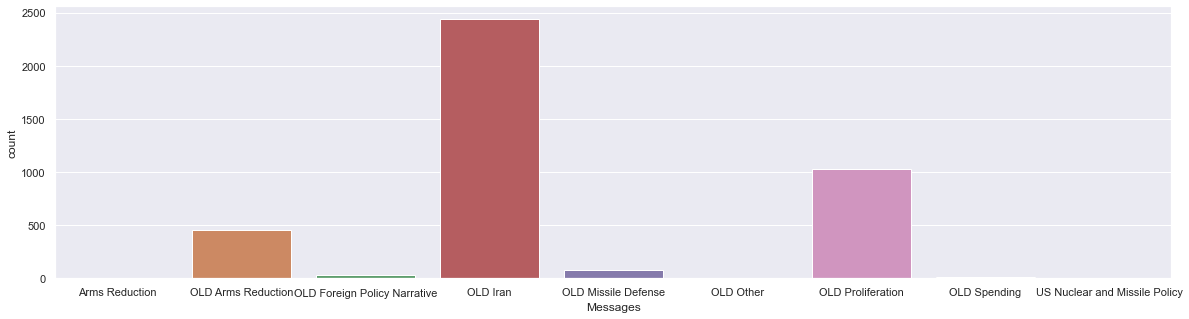

In [113]:
# try one treaty & relationship with messages
import seaborn as sns
sns.set(rc = {'figure.figsize':(20,5)})
sns.barplot(x = "Messages", y = "count", data = message_treaty_table('the nuclear nonproliferation treaty', 'Messages'))

In [114]:
treaties_unique = pd.DataFrame(merged_df['Treaties2'].value_counts())
treaties_unique.loc[treaties_unique['Treaties2'] > 50]

,Treaties2
the nuclear nonproliferation treaty,4043
the nonproliferation treaty,879
the north atlantic treaty,741
the new start treaty,545
the intermediaterange nuclear forces treaty,543
the treaty,353
the comprehensive test ban treaty,338
the antiballistic missile treaty,255
the inf treaty,209
the comprehensive nucleartestban treaty,167


# find proportion of articles with the given treaty in the different Messages


In [163]:
def message_treaty_props(treaty, topic_column):
    table =  merged_df.loc[merged_df['Treaties2'] == treaty].groupby(by = topic_column).count()
    table = table.reset_index().iloc[:,0:2].rename(columns = {'artdate' : 'count'})
    total = sum(table['count'])
    props = []
    for i in np.arange(len(table)):
        props.append(table['count'][i] / total)
    table['props'] = props
    table['treaty'] = treaty
    return table[['treaty', 'Messages', 'props']]


In [164]:
# treaties most --> least common
treaties_list = treaties_unique.index

In [167]:
treaty_message_table = message_treaty_props(treaties_list[0], 'Messages')
treaty_message_table= pd.pivot_table(treaty_message_table, values = 'props', index = ['treaty'], columns = ['Messages'])

for i in treaties_list[1:]:
    table = message_treaty_props(i, 'Messages')
    table = pd.pivot_table(table, values = 'props', index = ['treaty'], columns = ['Messages'])
    treaty_message_table = pd.concat([treaty_message_table, table])

In [174]:
pd.set_option('display.max_rows', len(treaty_message_table))
treaty_message_table

Messages,Arms Reduction,OLD Arms Reduction,OLD Foreign Policy Narrative,OLD Iran,OLD Missile Defense,OLD Other,OLD Proliferation,OLD Spending,US Nuclear and Missile Policy,OLD Sequestration
treaty,,,,,,,,,,
the nuclear nonproliferation treaty,0.000247,0.112046,0.006926,0.602770,0.018798,0.000742,0.255503,0.002721,0.000247,NaN
the nonproliferation treaty,NaN,0.151481,0.014806,0.604784,0.004556,NaN,0.222096,0.002278,NaN,NaN
the north atlantic treaty,NaN,0.074728,0.269022,0.088315,0.392663,NaN,0.144022,0.031250,NaN,NaN
the new start treaty,NaN,0.427523,0.095413,0.080734,0.163303,NaN,0.045872,0.179817,NaN,0.007339
the intermediaterange nuclear forces treaty,NaN,0.527002,0.089385,0.039106,0.195531,NaN,0.117318,0.031657,NaN,NaN
the treaty,NaN,0.321023,0.039773,0.289773,0.056818,NaN,0.292614,NaN,NaN,NaN
the comprehensive test ban treaty,NaN,0.674556,0.014793,0.032544,0.047337,NaN,0.174556,0.056213,NaN,NaN
the antiballistic missile treaty,NaN,0.172549,0.294118,NaN,0.482353,NaN,0.035294,0.015686,NaN,NaN
the inf treaty,NaN,0.473171,0.097561,0.058537,0.273171,NaN,0.068293,0.029268,NaN,NaN


In [183]:
pd.DataFrame(treaty_message_table.iloc[5, :]).idxmax()[0]

'OLD Arms Reduction'

In [184]:
# table with treaty & most common message (highest prop)
most_common_message = []
for i in np.arange(len(treaty_message_table)):
    most_common_message.append(pd.DataFrame(treaty_message_table.iloc[i, :]).idxmax()[0])

In [186]:
treaty_message_table['most common message'] = most_common_message

In [194]:
treaty_message_table = treaty_message_table.reset_index()[['treaty', 'most common message']]
treaty_message_table = treaty_message_table.rename_axis(None, axis=1)

In [195]:
treaty_message_table

,treaty,most common message
0,the nuclear nonproliferation treaty,OLD Iran
1,the nonproliferation treaty,OLD Iran
2,the north atlantic treaty,OLD Missile Defense
3,the new start treaty,OLD Arms Reduction
4,the intermediaterange nuclear forces treaty,OLD Arms Reduction
5,the treaty,OLD Arms Reduction
6,the comprehensive test ban treaty,OLD Arms Reduction
7,the antiballistic missile treaty,OLD Missile Defense
8,the inf treaty,OLD Arms Reduction
9,the comprehensive nucleartestban treaty,OLD Proliferation


Summary of the work:
1. message_treaty_table : for a given treaty, returns the count of articles with the treaty in each of the Message categories
2. treaties_unique : different treaties and their value counts (sorted most common —> least common)
3. message_treaty_props : returns the proportion of articles with the treaty in different message categories
4. treaty_message_table : rows are the treaties, columns are different message categories, values are the proportions
5. treaty_message_table : table with the different treaties and most common message

Future work: 
- see if the most common message is actually significant enough / high enough proportion to classify
- do similar analysis for people